Osnabrück University - A&C: Computational Cognition (Summer Term 2019)

# Exercise Sheet 07: EEG simulation & filtering in 2-D

## Introduction

This week's sheet should be solved and handed in at 14:00 at **Tuesday, June 18, 2019**. If you need help (and Google and other resources were not enough), feel free to contact your tutors. Please push your results to your Github group folder.

In this sheet we are going dig deeper into signal processing. Specifically, we will learn how the basic concepts in signal processing expand to 2-D space. You will need to have understandings of what fourier transform and inverse transform do and what kind of effect convolution has.

 Let's say your friend wants to send you a deep picture per messaging app. But he is too afraid that the server might get hacked. Therefore he decides to add some noise in his picture and just sends you the 2d shaped text file of the image. Now you have to denoise the image to see it. Surely you can use a simple filtering function to achieve this, but that sounds too boring for you. Instead, you want to convolve the filter and the image in a spatial domain.

In [1]:
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy import fftpack
from scipy import signal

## Assignment 0: Peer review for sheet 07 [0 pts]

This week there will be no peer-review for obvious reasons.

## Assignment 1: Simulate 4-channel EEG signal [4 pts]

Before starting with the image, we will try to approximate an actual EEG signal as an extension from next week's sheet. Although our later EEG data will be composed of 64 channels, we will stick with 4 for simplicity. 

### a) Generate signal [3 pts]

Write a function that creates the signal for one channel, given a certain frequency-list (4 different frequencies) and the length of the signal. 
Within the function:
- First, define a sampling rate of 1000 Hz and a time-window of 1 second (i.e. 1000 ms)
- Define a list that assigns an amplitude to each element of frequencyList: For this, randomly draw with replacement from a range between 0 and 30 (hint: you need as many amplitude-samples as number of elements in frequencyList, checkout *np.random.choice*)
- Create each signal component with given frequency and amplitude. Add them all up.
- Add a small Gaussian noise to the signal.

In [2]:
def generateSignal(frequencyList,signalLen=1000):
    '''
    - Simulate EEG Signal: Combine sinusoids of random frequencies with random bursts
    - Use a windowing method to generate the frequency bursts in random time windows
    - Do this 4 times to simulate 4 channels
    '''
    # sampling rate, Hz
    fs = 1000
    # time axis
    t = np.arange(signalLen, dtype=np.float)/1000

    signal = 0
    # define a list of amplitudes between 0 and 30 to randomly sample from
    amplit_list = list(range(0,30))
    amplit = np.random.choice(amplit_list,len(frequencyList))
    j=0
    for i in frequencyList:
        s1 =  amplit[j] * np.sin(np.pi * 2. * i * t)
        signal += s1
        j+=1

    # create some random noise (gaussian distributed)
    noise = np.random.normal(0,20,1000)
    # add noise to signal
    signal += noise

    return signal

### b) Plot [1 pt]
Once you wrote the function, use it to create 4 differnet signals (which each represent a channel). To make it more realistic, randomly sample frequencies of each signal from a common EEG frequency-band. These 4 common EEG frequency-bands are already given below.
 
Lastly, plot these 4 different signals.

In [3]:
# define frequency-bands typical for EEG data
delta = list(range(0,4))
theta = list(range(4,8))
alpha = list(range(8,14))
beta = list(range(13,31))
gamma = list(range(31,120))
frexlist = [delta, theta, alpha, beta, gamma]

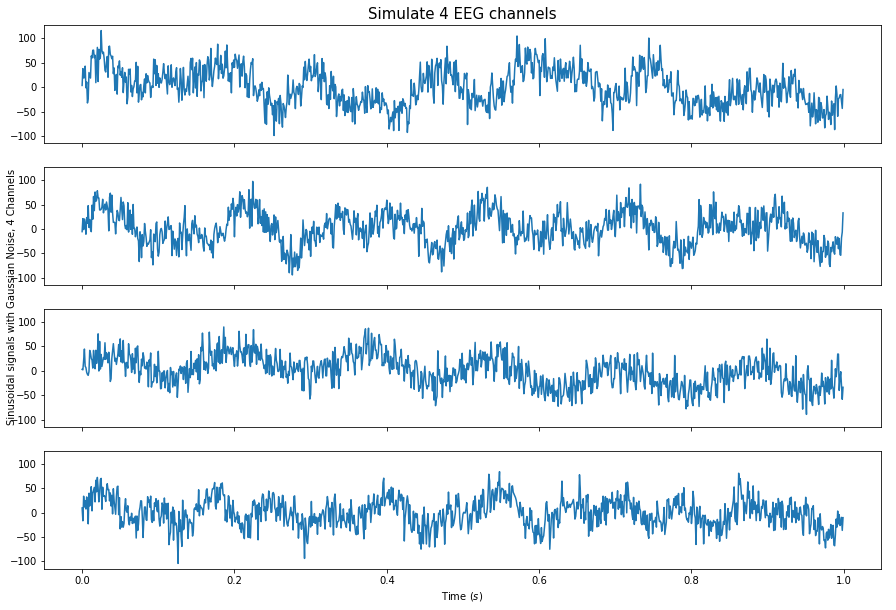

In [24]:
# create 4 signals for each channel, with random frequency combinations
f1 = random.sample(frexlist, k=1)[0]
# f2 = random.sample(frexlist, k=1)[0]
# f3 = random.sample(frexlist, k=1)[0]
# f4 = random.sample(frexlist, k=1)[0]

def randsample():
    """
    aux function to select random frequency from each of frequency band
    """
    samplelist = []
    for band in frexlist:
        samplelist.append(random.sample(band,k=1)[0])
    return samplelist

f1 = randsample()
f2 = randsample()
f3 = randsample()
f4 = randsample()
s1 = generateSignal(f1)
s2 = generateSignal(f2)
s3 = generateSignal(f3)
s4 = generateSignal(f4)

#Write code to plot this signal vs. time
t = np.arange(len(s1), dtype=np.float)/1000

fig, axs = plt.subplots(4, 1, sharex=True, sharey=True, figsize=(15,10))

# add big shared axes, hide frame
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel('Time ($s$)')
plt.ylabel('Sinusoidal signals with Gaussian Noise, 4 Channels')
plt.title('Simulate 4 EEG channels', fontsize = 15)

# Plot each graph
axs[0].plot(t, s1)
axs[1].plot(t, s2)
axs[2].plot(t, s3)
axs[3].plot(t, s4)

### BONUS!
### a) Power-Spectogram
compute and plot the nice and colorful power-spectogram of our signals with *plt.specgram*

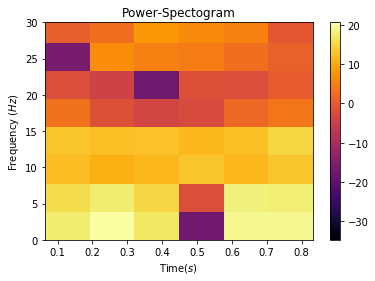

In [6]:
sig = s2 # you can of course plot all 4 different signals
# powerSpectrum, freqenciesFound, ime, imageAxis = plt.specgram(sig, Fs=1000)
plt.specgram(sig, Fs=1000, cmap="inferno")
plt.colorbar()
plt.xlabel('Time($s$)')
plt.ylabel('Frequency ($Hz$)')
plt.ylim(0,30)
plt.title('Power-Spectogram')

## Assignment 2: Load the data [1 pts]
Now let's start cracking the puzzle. Because your friend just sent you some text file, you need to load them into an image.
- First load the text file into a numpy array.
- Plot this numpy array. Use a gray colormap.

In [7]:
# https://stackoverflow.com/questions/12201577/how-can-i-convert-an-rgb-image-into-grayscale-in-python
# code used to create a noisy grayscale image and save as txt file, won't be handed to the student
img_org = matplotlib.image.imread("img/Brain1.jpg") 
gray = lambda rgb : np.dot(rgb[... , :3] , [0.299 , 0.587, 0.114]) # convert to grayscale
img_gray = gray(img_org)
img_noisy = img_gray + np.random.normal(0, 160, img_gray.shape) # add noise
np.savetxt("important.txt", img_noisy, fmt="%.2f")

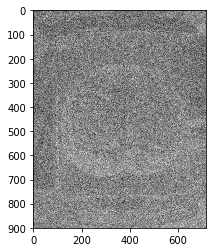

In [8]:
img_noisy = np.loadtxt("important.txt")
plt.imshow(img_noisy,cmap="gray")


## Asignment 3: Fourier transform [2 pts]
Do a fourier transform on the image.
- Don't panic. It's just the same concept, only in a 2-D space rather than in a 1-D space.
- You should plot the power spectrum of the fourier transformed image at the end. 
- See https://www.gaussianwaves.com/2015/11/interpreting-fft-results-obtaining-magnitude-and-phase-information/ for differences between magnitiude, phase and power (amplitude).
- Use log scale in the plot.

/home/minseok/anaconda3/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


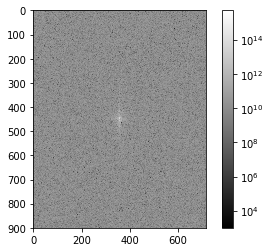

In [9]:
# https://www.astrobetter.com/blog/2010/03/03/fourier-transforms-of-images-in-python/
space_to_freq = lambda img : fftpack.fftshift(fftpack.fft2(img)) # compute fourier transform
powerspec = lambda ft : np.abs(ft)**2 # compute power spectrum
fourier_img = space_to_freq(img_noisy)
power_img = powerspec(fourier_img)
plt.imshow(power_img, norm = matplotlib.colors.LogNorm(vmin=1000), cmap="gray") # use log scale
plt.colorbar()

https://dsp.stackexchange.com/questions/4691/what-is-the-difference-between-psd-and-squared-magnitude-of-frequency-spectrum

https://math.stackexchange.com/questions/1946343/fourier-series-and-fourier-transform-amplitude-spectrum-vs-frequency-spectrum/1953123

Difference between power and amplitude

## Assignment 4: Create low pass filter [2 pts]
To filter the image, you need a filter. We are going to use a low pass filter (2-D Gaussian). 
- Your distribution should be rotationally symmetric for every angle.
- The filter should have 120 x 120 size, and the standard deviation should be 3.
- In our case it's easy to go from 1-D Gaussian distribution to 2-D Gaussian distribution, because there are no interaction between two dimensions (covariance matrix would be diagonal).
- Plot your filter.

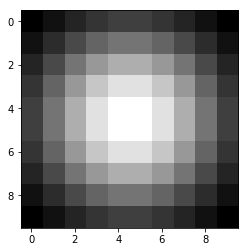

In [19]:
kern1d = signal.gaussian(10,3) # 1-D Gaussian
kern2d = np.outer(kern1d,kern1d) # 2-D Gaussian
plt.imshow(kern2d, cmap="gray")

## Assignment 5: Back to space [2 pts]
Right now the picture and the filters are both in frequency domain. Let's bring them back to the spatial domain. For this, you can use an inverse fourier transform function (I know, we computed fourier transform of the picture for nothing). 
- Compute the inverse fourier transform for both the image and the kernel.
- Compute power spectrum of these.

In [20]:
img_in_space = powerspec(fftpack.ifft2(fourier_img))
filter_in_space = powerspec(fftpack.ifft2(space_to_freq(kern2d)))

## Assignment 6: Convolution [2 pts]

To boost your intuition of convoultion in 2-d space, I recommend the following blog article.
http://www.songho.ca/dsp/convolution/convolution2d_example.html


We are almost there. Now we just have to convolve the image and the filter in spatial domain (use the computed power spectra of assignment 5 for this) and plot the picture. Do you recognise the object in the picture?

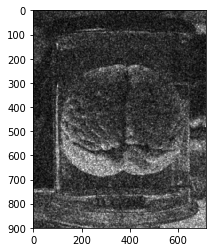

In [21]:
plt.imshow(ndimage.convolve(img_in_space,filter_in_space), cmap="gray")

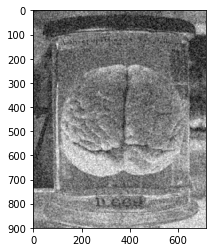

In [27]:
plt.imshow(ndimage.convolve(img_noisy,filter_in_space), cmap="gray")

What do you see? 

Brain in a vat